In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network
## Session 29 : torch FRCNN
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com"/>

Faster R-CNN (FRCNN) is a deep learning model specifically designed for object detection tasks, meaning it identifies and classifies multiple objects within an image and draws bounding boxes around them. It builds on the original Region-Based Convolutional Neural Networks (R-CNN) and its predecessor Fast R-CNN, improving efficiency and accuracy. For this demo, we will be using PyTorch version of the Faster RCNN object detection model. They call it the Faster RCNN ResNet50 FPN V2.

### Architecture of Faster R-CNN
#### Convolutional Layers (Feature Extraction):

- This first stage uses a convolutional neural network (usually a backbone like ResNet, VGG, or Inception) to extract feature maps from the input image.
- These feature maps contain spatial information about the various objects and regions in the image.
#### Region Proposal Network (RPN):

- The RPN generates potential regions or object proposals. It’s a lightweight neural network that proposes regions likely to contain objects.
- It outputs two results:
    - Objectness scores: Probabilities that a region contains an object or background.
    - Bounding box coordinates: Predictions for bounding box locations.
- The RPN slides over the feature map, examining each location to predict regions likely to contain objects. Non-Maximum Suppression (NMS) is then applied to eliminate redundant proposals.
#### ROI Pooling:

- Faster R-CNN uses a technique called ROI (Region of Interest) Pooling, which extracts fixed-size feature maps from proposals.
- ROI Pooling applies spatial transformation to maintain a consistent feature map size for each region, making them compatible with the next stage.
#### Fully Connected Layers (Classification and Bounding Box Regression):

- Each fixed-size feature map from ROI Pooling is passed to fully connected layers to classify the objects and refine the bounding box coordinates further.
#### Output:

The final output includes bounding box coordinates, classes, and a class label for each detected object in the image.

<img src = '../../images/faster_R_CNN.png'>

[Figure 2: Faster R-CNN is a single, unified network for object detection.](https://arxiv.org/pdf/1506.01497)

The RPN module serves as the 'attention' of this unified network.


In [2]:
### Import Libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.transforms import functional as F
import torchvision.transforms as transforms

from PIL import Image

import cv2

#from utils.helper import fn_plot_confusion_matrix, fn_plot_tf_hist

In [3]:
# Some basic parameters

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'basic_operations' # location of the images
modelDir = '../models'
altName = 'rcnn'


RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
EPOCHS = 100 # number of cycles to run
THRESHOLD = 0.8


# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,12),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

## All about CUDA

In [4]:
print ('Is CUDA available: ', torch.cuda.is_available())
print ('CUDA version: ', torch.version.cuda )
print ('Current Device ID: ', torch.cuda.current_device())
print ('Name of the CUDA device: ', torch.cuda.get_device_name(torch.cuda.current_device()))

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Is CUDA available:  True
CUDA version:  12.4
Current Device ID:  0
Name of the CUDA device:  NVIDIA GeForce RTX 3060 Laptop GPU
Using cuda device


# Helper Functions

#### The COCO Dataset Category Names

In [5]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Create different colors for each class.
COLORS = np.random.uniform(0, 255, size=(len(COCO_INSTANCE_CATEGORY_NAMES), 3))
# Define the torchvision image transforms.
transform = transforms.Compose([
    transforms.ToTensor(),
])

##### Predict Function

In [ ]:
def predict(image, model, device, detection_threshold = 0.5, coco_names=COCO_INSTANCE_CATEGORY_NAMES):
    """
    Predict the output of an image after forward pass through
    the model and return the bounding boxes, class names, and 
    class labels. 
    """
    # Transform the image to tensor.
    image = transform(image).to(device)
    # Add a batch dimension.
    image = image.unsqueeze(0) 
    # Get the predictions on the image.
    with torch.inference_mode():
        outputs = model(image) 
    # Get score for all the predicted objects.
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    # Get all the predicted bounding boxes.
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # Get boxes above the threshold score.
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    labels = outputs[0]['labels'][:len(boxes)]
    # Get all the predicted class names.
    pred_classes = [coco_names[i] for i in labels.cpu().numpy()]
    return boxes, pred_classes, labels

In [7]:
def draw_boxes(boxes, classes, labels, image):
    '''`
    Draws bounding boxes with labels on an image to represent detected objects.

    Args:
        boxes (list): A list of bounding box coordinates for each detected object,
                    where each box is represented by [x_min, y_min, x_max, y_max].
        classes (list): A list of class names corresponding to each bounding box.
        labels (list): A list of label indices for each detected object; these are 
                    used to pick specific colors for each class.
        image (numpy array): The image on which to draw the bounding boxes.

    Returns:
        image (numpy array): The modified image with bounding boxes and labels drawn on it.
    '''

    # Determine line width for the bounding boxes based on image dimensions.
    # This sets the line width to a fraction of the sum of image height and width,
    # with a minimum width of 2 to ensure visibility.
    lw = max(round(sum(image.shape) / 2 * 0.001), 2)

    # Determine font thickness, set to one less than line width but with a minimum of 1.
    tf = max(lw - 1, 2)

    # Loop through each bounding box to draw it on the image.
    for i, box in enumerate(boxes):
        # Select a color for the bounding box from the COLORS array, using the label index.
        # COLORS is a predefined array where each index corresponds to a specific color.
        color = COLORS[labels[i]]

        # Draw the bounding box as a rectangle on the image.
        
        cv2.rectangle(
            img=image,
            pt1=(int(box[0]), int(box[1])), # top-left corner of the box.
            pt2=(int(box[2]), int(box[3])), # bottom-right corner of the box.
            color=color[::-1],              # Reversed to BGR for OpenCV
            thickness=lw                    # set to lw to maintain consistency with text.
        )

        # Add text to label the bounding box with the class name.        
        cv2.putText(
            img=image, 
            text=classes[i], 
            org=(int(box[0]), int(box[1] - 5)),  # 5 pixels above the top-left corner
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw / 2,                    # proportional to line width for a balanced appearance.
            color=color[::-1],                   # Reversed to BGR for OpenCV
            thickness=tf,                        # set to tf for good legibility.
            lineType=cv2.LINE_AA                 # anti-aliased text for smoothness.
        )

    # Return the modified image with all bounding boxes and labels.
    return image

In [8]:
# Load a pre-trained Faster R-CNN model
def get_model(device='cuda'):
    
    # Load the model.
    model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')

    # Load the model onto the computation device.
    model = model.eval().to(device)
    
    return model

In [9]:
model = get_model(device)

## Load Image

In [10]:
# Load the input image and apply transformations
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    
    # Create a BGR copy of the image for annotation.
    image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    return image, image_bgr


In [11]:
imgName = 'road_3.png' # 'IMG_1295.JPG'
# Load an example image
image_path = os.path.join(inpDir, subDir, imgName)  # specify your image path
image, image_bgr = load_image(image_path)

In [ ]:
# Detect outputs.
with torch.inference_mode():
    boxes, classes, labels = predict(image, model, device, detection_threshold= THRESHOLD)
# Draw bounding boxes.
image = draw_boxes(boxes, classes, labels, image_bgr)


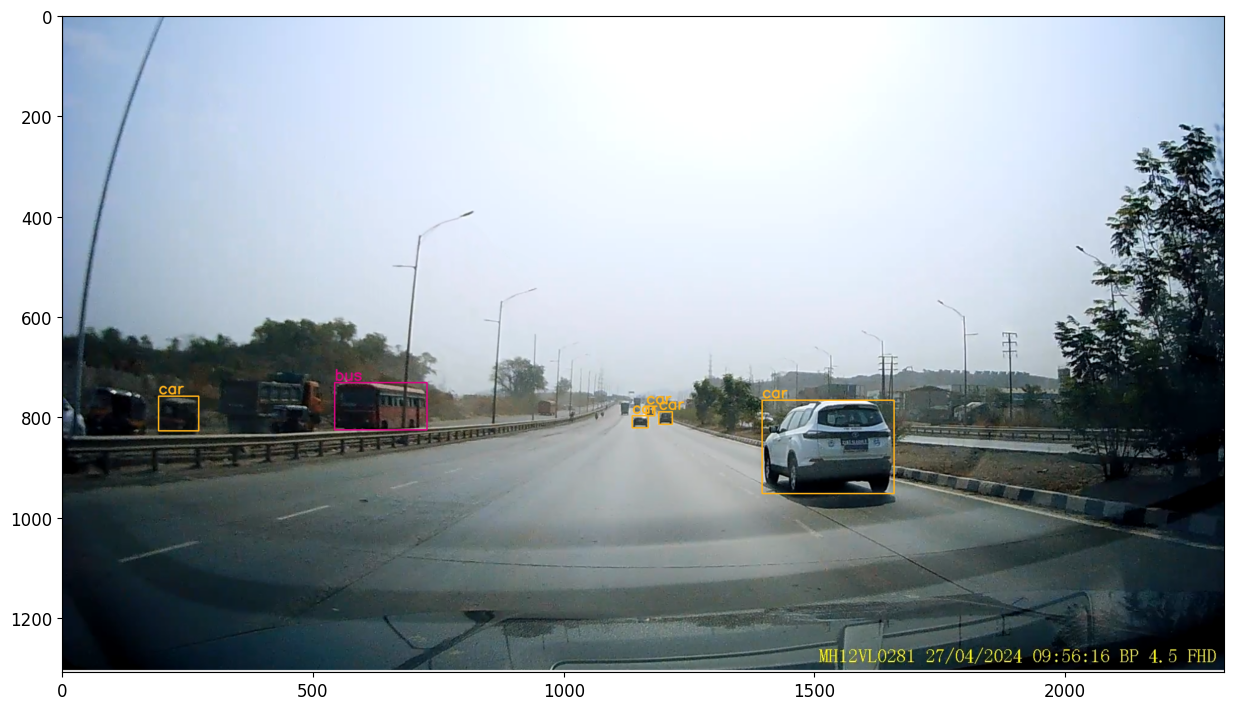

In [13]:
rgbIm = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(rgbIm);

In [17]:
vidName = 'VID_20241003101647_F.MOV' #'VID_20240320164819_F.MOV' # 'VID_20240320164919_F.MOV'
vidFilePath = os.path.join(inpDir, subDir, vidName)

cap = cv2.VideoCapture(vidFilePath)

In [18]:
if (cap.isOpened() == False):
    print('Error while trying to read video. Please check path again')
# Get the frame width and height.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# for saving the file
save_name = f"{vidFilePath[-1].split('.')[0]}_t{''.join(str(THRESHOLD).split('.'))}_{altName}"
# Define codec and create VideoWriter object .
out = cv2.VideoWriter(os.path.join(outDir, f"{save_name}.mp4"), 
                      cv2.VideoWriter_fourcc(*'mp4v'), 30, 
                      (frame_width, frame_height))
frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second.

In [ ]:
# Read until end of video.
while(cap.isOpened):
    # Capture each frame of the video.
    ret, frame = cap.read()
    if ret:
        frame_copy = frame.copy()
        frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
        # Get the start time.
        start_time = time.time()
        with torch.inference_mode():
            # Get predictions for the current frame.
            boxes, classes, labels = predict( frame, model, device, THRESHOLD)
        
        # Draw boxes and show current frame on screen.
        image = draw_boxes(boxes, classes, labels, frame)
        # Get the end time.
        end_time = time.time()
        # Get the fps.
        fps = 1 / (end_time - start_time)
        # Add fps to total fps.
        total_fps += fps
        # Increment frame count.
        frame_count += 1
        # Write the FPS on the current frame.
        cv2.putText(
            img=image, 
            text=f"{fps:.3f} FPS", 
            org=(15, 30), 
            fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, 
            color=(0, 255, 0), 
            thickness=2,
            lineType=cv2.LINE_AA
        )
        # Convert from BGR to RGB color format.
        cv2.imshow('image', image)
        out.write(image)
        # Press `q` to exit.
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
# Release VideoCapture().
cap.release()
# Close all frames and video windows.
cv2.destroyAllWindows()
# Calculate and print the average FPS.
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")


Average FPS: 7.182
